## Import libraries and read the data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

FIG_SIZE = (10, 8)
FONT_SIZE = "22"
FONT_WEIGHT = "bold"
MARKER_SIZE = 10
LINE_WIDTH = 2
GRID = True
Y_LIM_ET = (0, 1800)
Y_LIM_TPF = (0, 225)
Y_SCALE = "linear"
ERRORBAR = ("ci", 95)

rc = {
    "figure.figsize": FIG_SIZE, "figure.titlesize": 20,
    "axes.labelsize": FONT_SIZE, "axes.labelweight": FONT_WEIGHT,
    "legend.fontsize": FONT_SIZE, "legend.title_fontsize": FONT_SIZE,
    "xtick.labelsize": FONT_SIZE, "ytick.labelsize": FONT_SIZE,
    "lines.markersize": MARKER_SIZE, "lines.linewidth": LINE_WIDTH,
    "axes.grid": GRID,
}

sns.set_theme(style="whitegrid", palette="colorblind", context="paper", rc=rc)

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

df = pd.read_parquet('../results/scalability.parquet')
NODES_TO_REMOVE = [16, 32]
df = df[~df["Nodes"].isin(NODES_TO_REMOVE)]

NODES = sorted(list(df["Nodes"].unique()))
NODES = [str(n) for n in NODES]
df["Nodes"] = df["Nodes"].astype(str) 

TOPOLOGIES = df["Topology"].unique()
PLOTS_DIR = Path("../plots") / "scalability"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# CATPLOTS_DIR = PLOTS_DIR / "catplots"
# CATPLOTS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
df_success = df[~df['Output'].isin(['no_result', 'timeout'])]
df_no_result = df[df['Output'] == 'no_result']
df_fails = df[df['Output'].isin(['no_result', 'timeout'])]

In [4]:
from typing import Callable

def by_topology(df_all: pd.DataFrame, fn: Callable, **kwargs):
    for topology in df_all["Topology"].unique():
        for rp in list(df_all["RepProb"].unique()):
            df_topo = df_all[(df_all['Topology'] == topology) & (df_all['RepProb'] == rp)]
            fn(df_topo, title=f"{topology}-{rp}", topology=topology, rp=rp, **kwargs)

    # fn(df_all, title='All Topologies', **kwargs)

In [5]:
def percentile(df_raw: pd.DataFrame, field: str, percentile: float = 0.90):
    
    df_raw.loc[:, "percentile"] = df_raw.groupby("Nodes")[field].transform(lambda x: x.quantile(percentile))
    df_raw = df_raw[df_raw[field] <= df_raw["percentile"]]

    return df_raw

In [6]:
from scipy.stats import zscore

def remove_outliers_zscore(df_raw: pd.DataFrame, field: str , threshold: int = 3):
    z = np.abs(zscore(df_raw[field]))
    df_raw.loc[z > threshold, field] = df_raw[field].median()
    return df_raw

# EXECUTION TIMES

#### BY TOPOLOGY

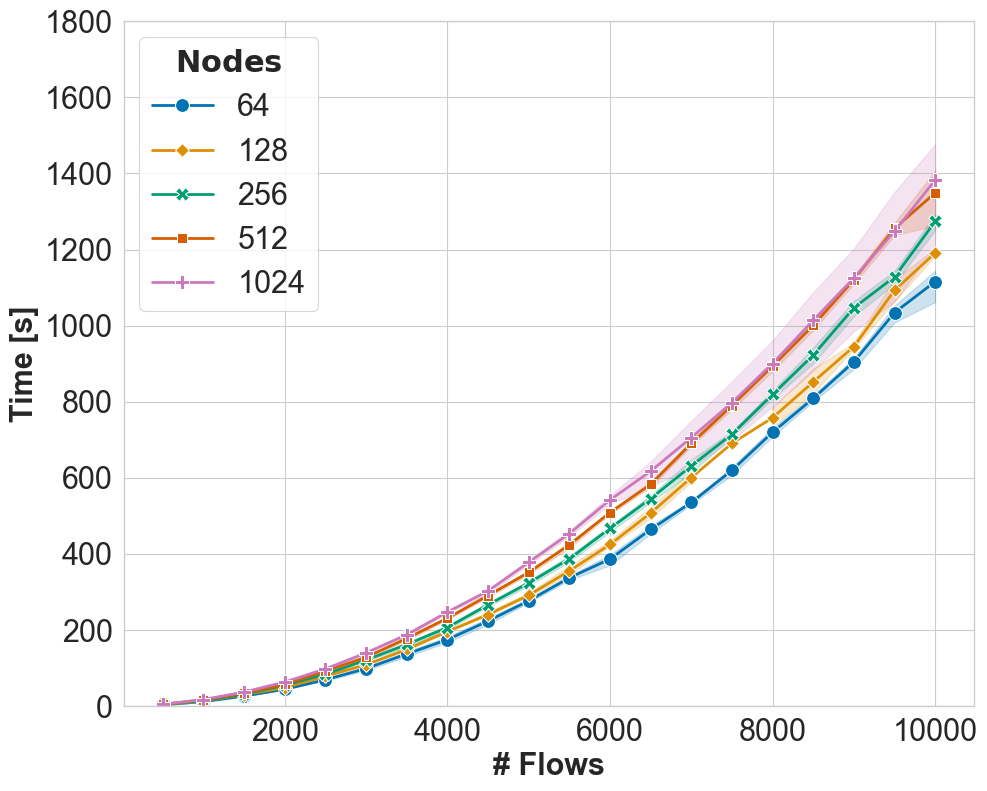

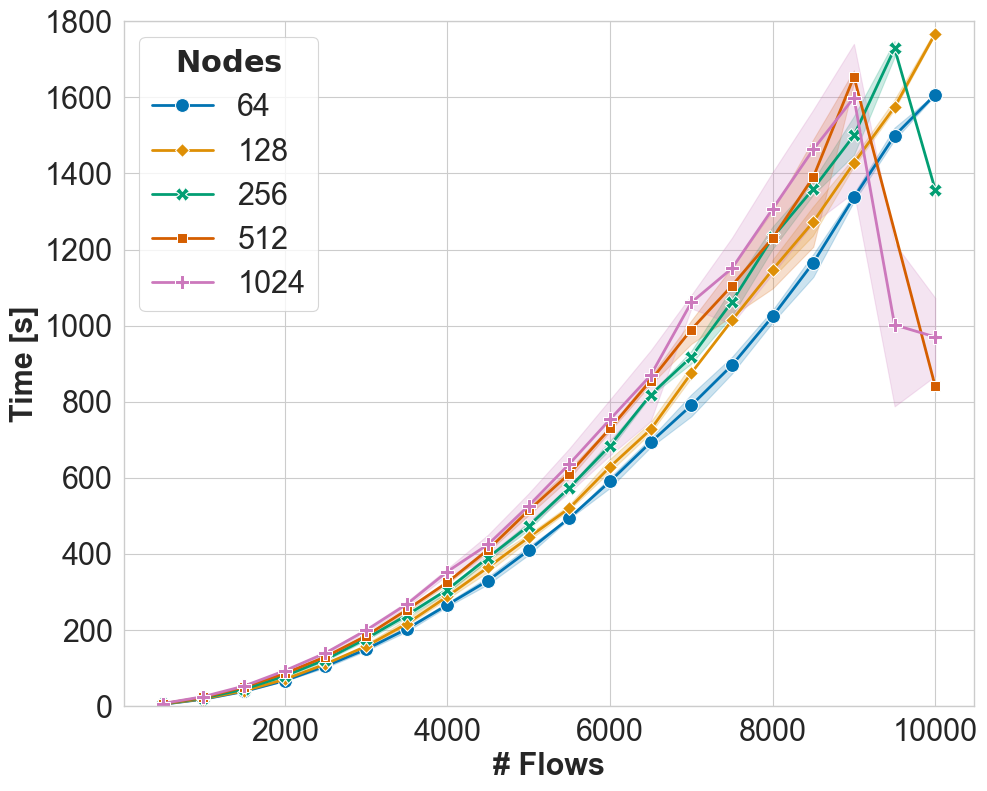

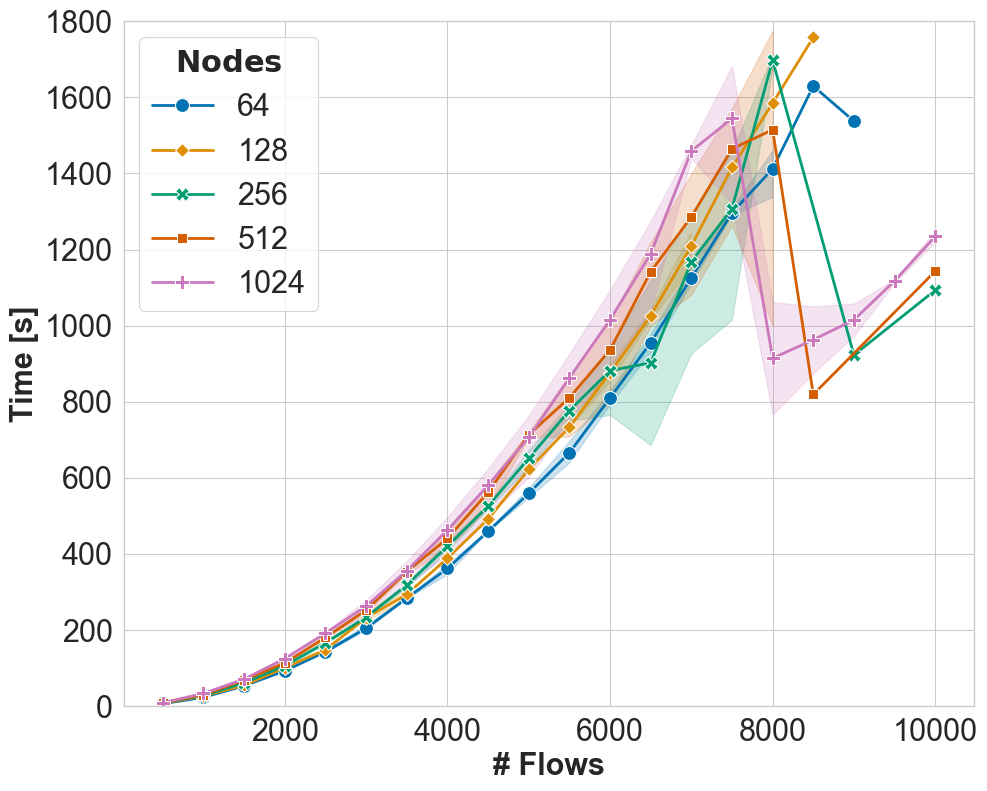

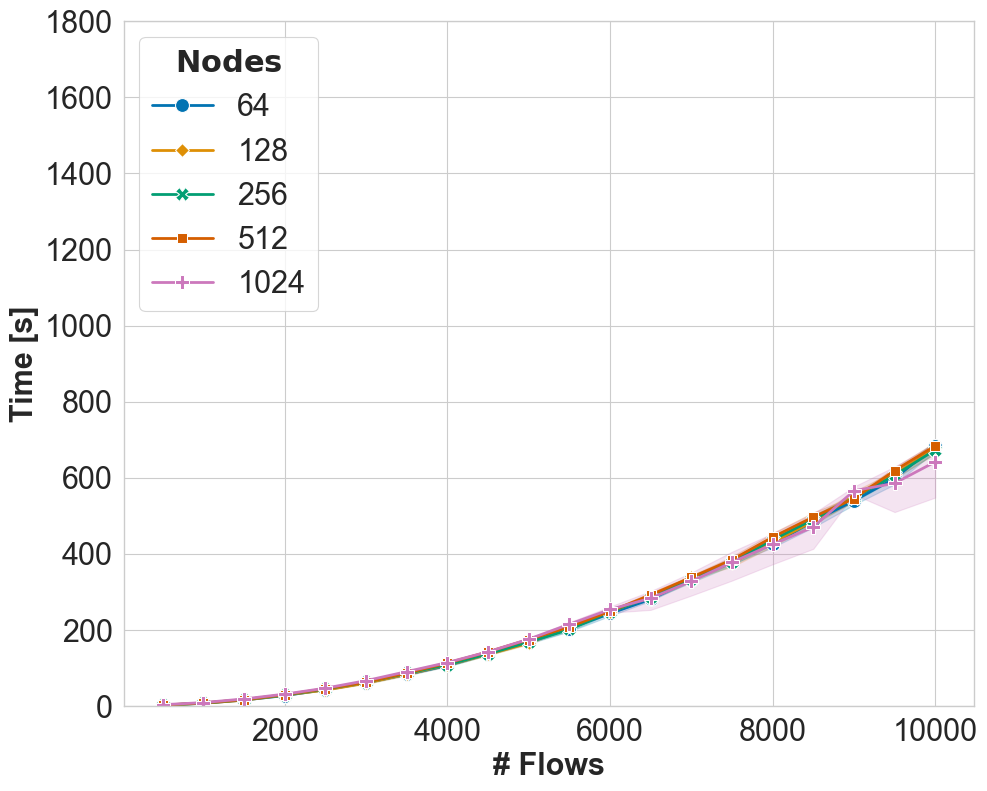

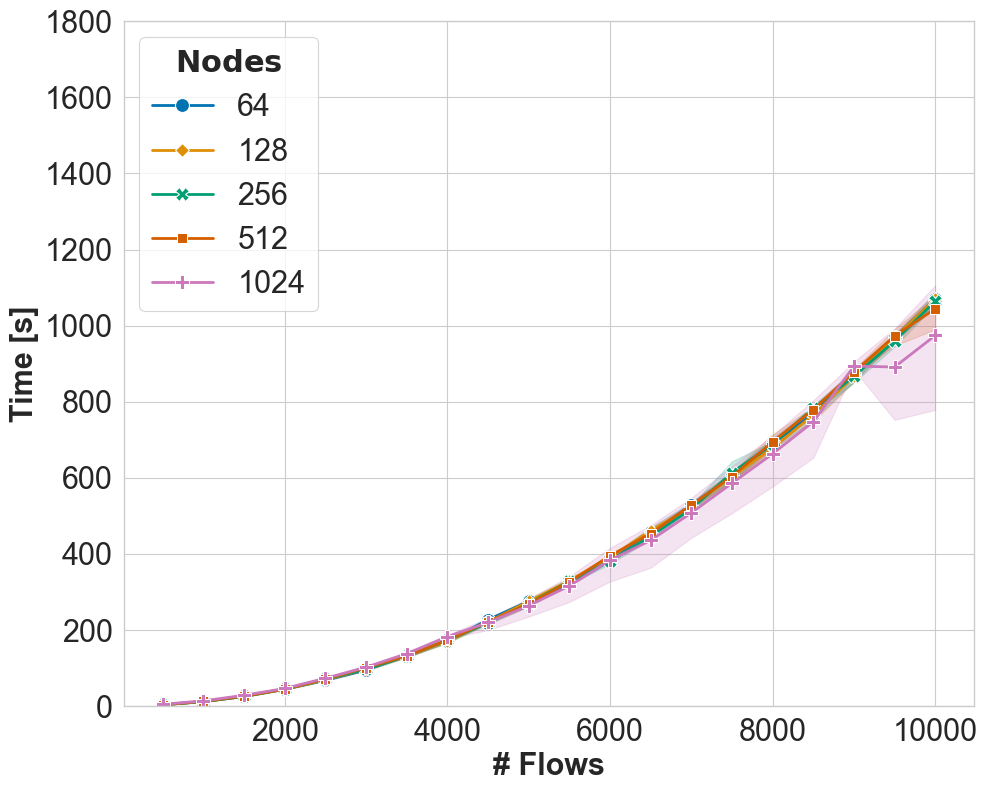

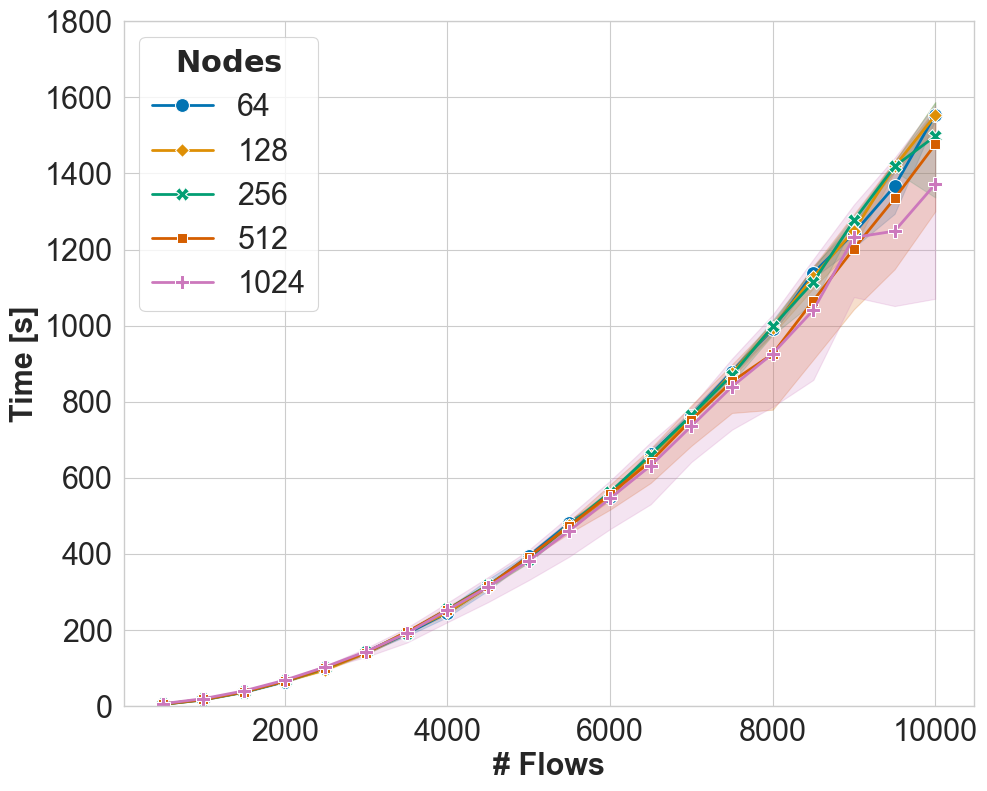

In [7]:
def execution_times(df_et: pd.DataFrame, title: str, **kwargs):
    plt.figure(figsize=FIG_SIZE)
    
    sns.lineplot(
        data=df_et,
        x="Flows",
        y="Time",
        hue="Nodes",
        style="Nodes",
        errorbar=ERRORBAR,
        dashes=False,
        markers=True,
        hue_order=NODES,
    )

    # Set plot title and labels
    # plt.title(title, fontsize=FONT_SIZE)
    plt.xlabel('# Flows', fontsize=FONT_SIZE)
    plt.ylabel('Time [s]', fontsize=FONT_SIZE)
    plt.yscale(Y_SCALE)
    plt.ylim(Y_LIM_ET)
    plt.legend(title=r'$\bf{Nodes}$', loc='upper left', title_fontsize=FONT_SIZE)
    plt.tight_layout()

    path = PLOTS_DIR / "execution-times" / kwargs["topology"]
    path.mkdir(parents=True, exist_ok=True)
    plt.savefig(path / f"{kwargs['rp']}.pdf", format='pdf', dpi=600)
    plt.show()

by_topology(df_success, execution_times)

#### CATPLOT

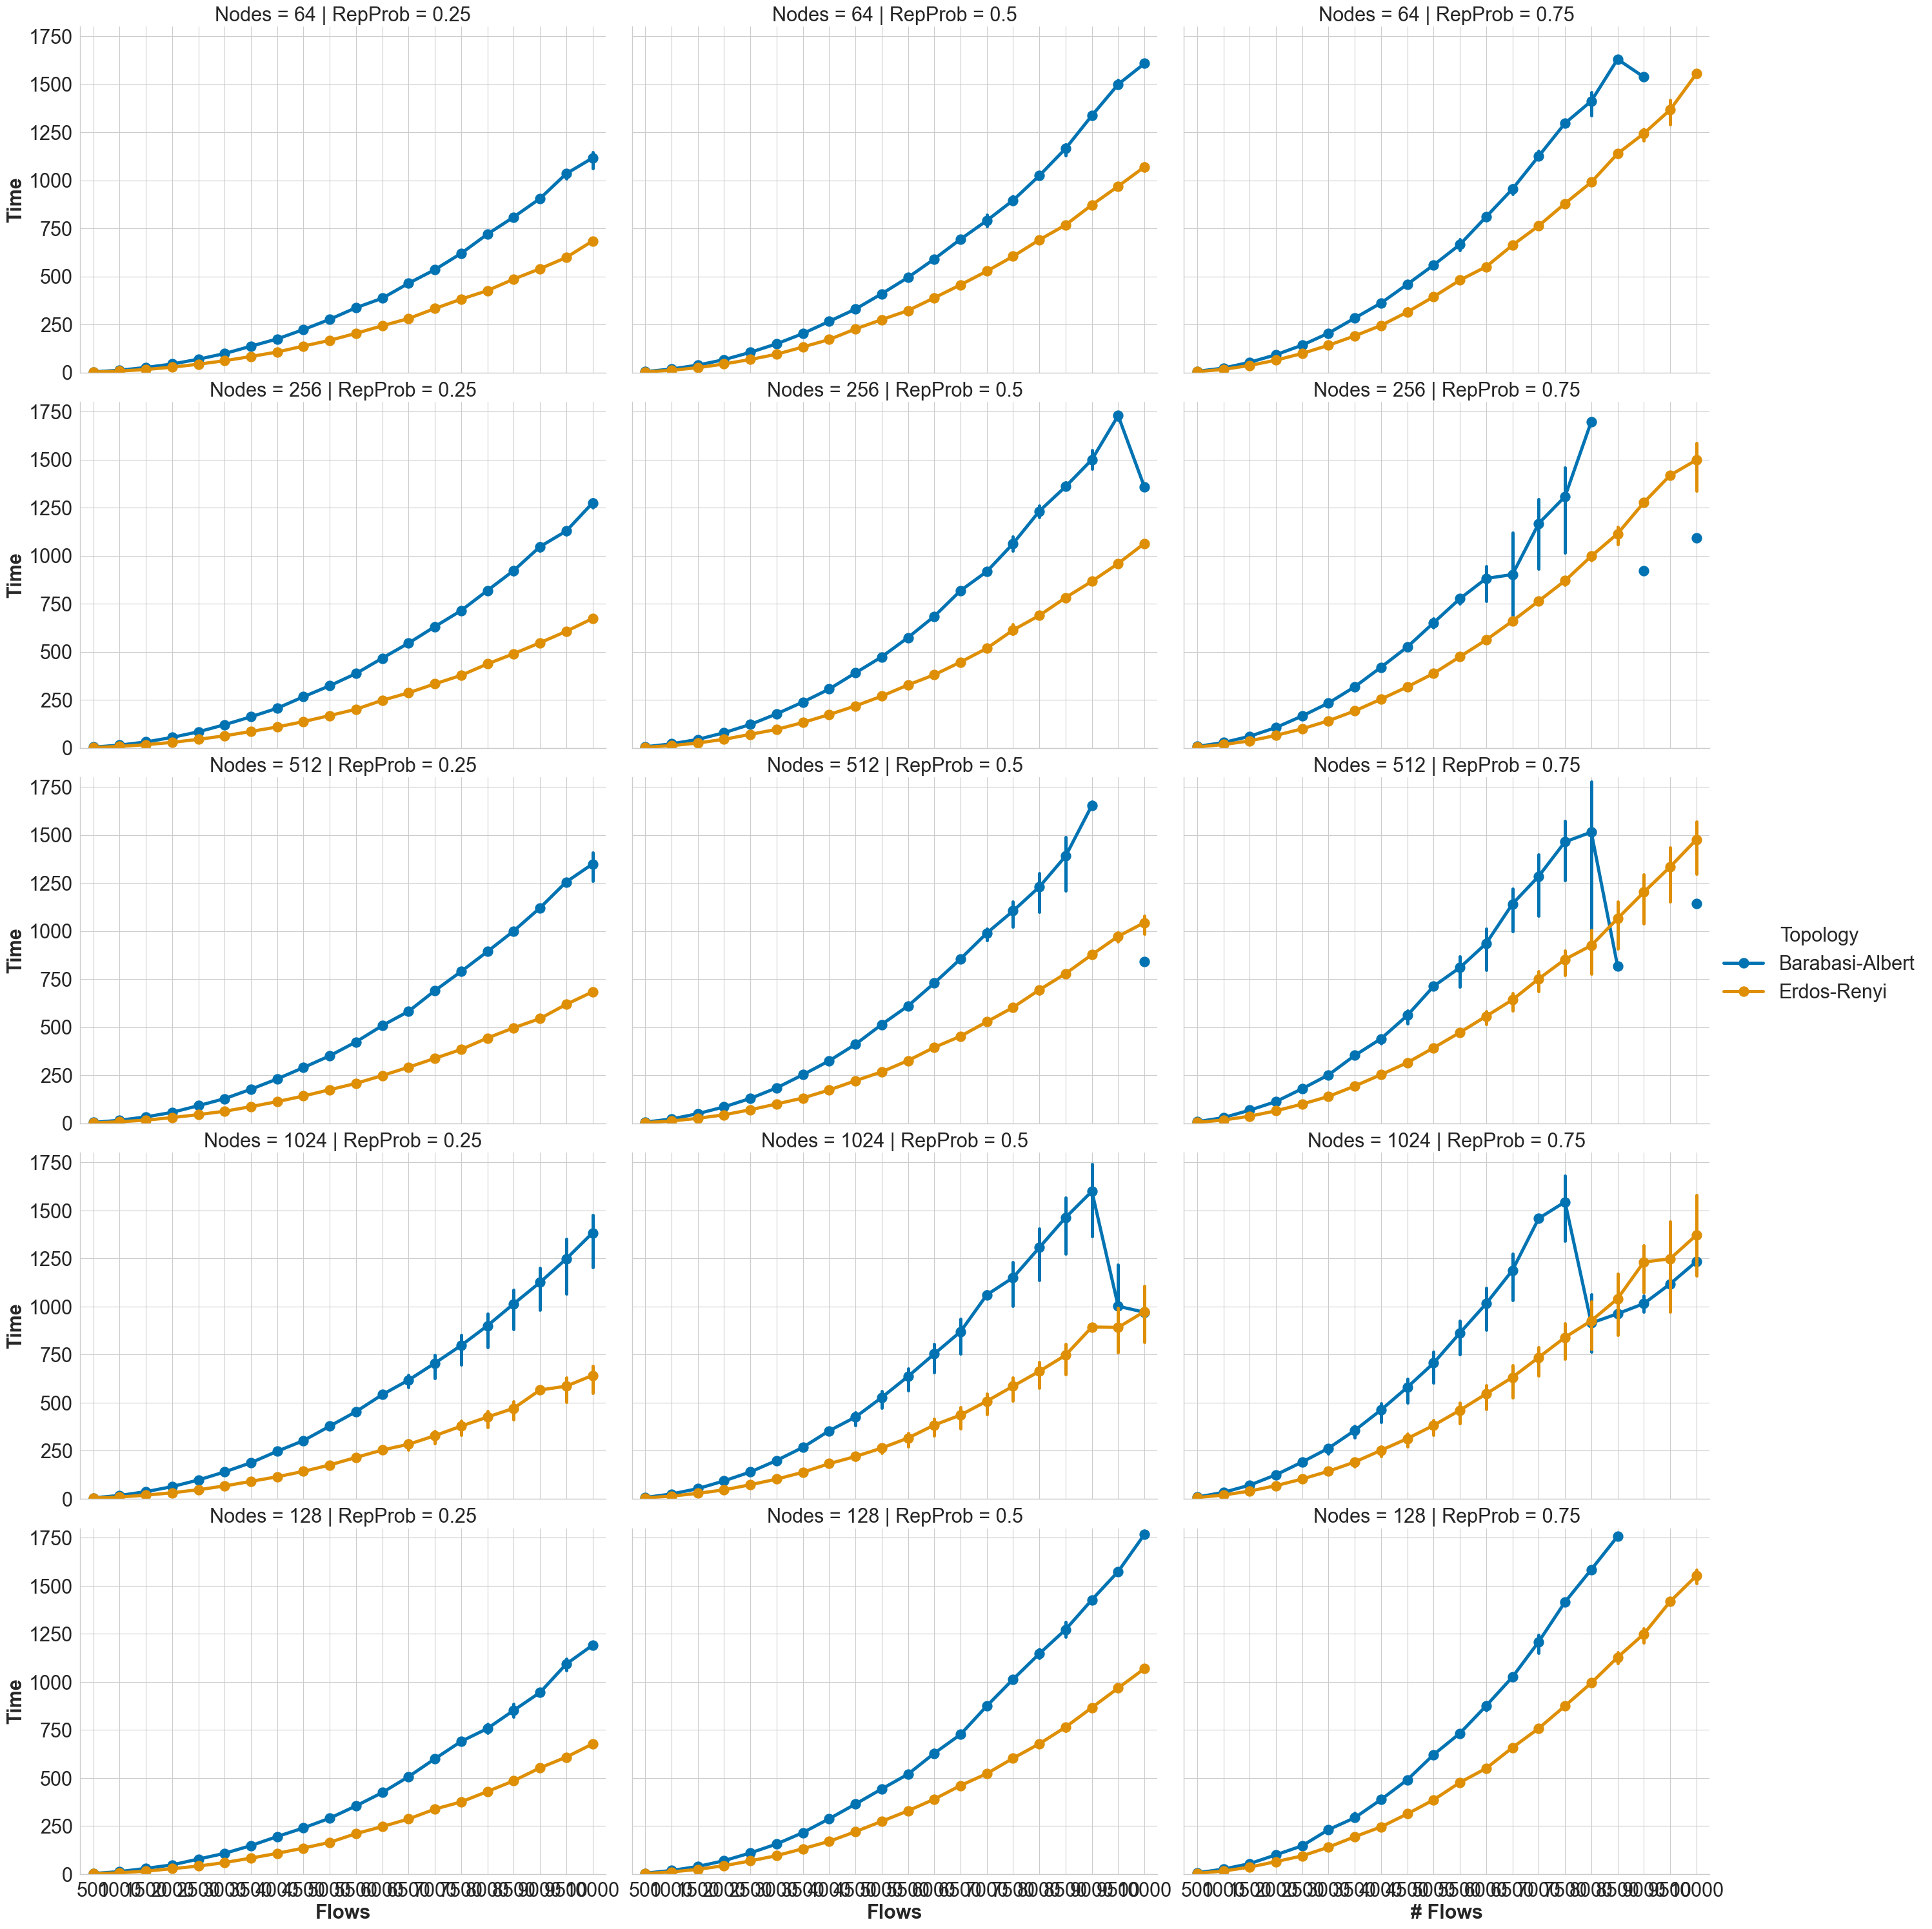

In [8]:
# execution_times catplot, directly in the code cell not with a function
execution_times_catplot = sns.catplot(
    data=df_success,
    x="Flows",
    y="Time",
    hue="Topology",
    col="RepProb",
    row="Nodes",
    kind="point",
    legend_out=True,
    height=6,
    aspect=1.5,
    hue_order=sorted(TOPOLOGIES),
    sharex=True,
    sharey=True
)

for ax in execution_times_catplot.axes.flat:
    ax.grid(True)
    ax.set_yscale(Y_SCALE)
    ax.set_ylim(Y_LIM_ET)
    # ticks = list(sorted(df_success["Flows"].unique()))
    # show_ticks = [i for i in ticks if i % 500 == 0]
    # ax.set_xticks(list(range(len(ticks))))
    # ax.set_xticklabels([str(t) if t in show_ticks else "" for t in ticks])

# Set plot title and labels
plt.xlabel('# Flows')
plt.ylabel('Time')
# plt.savefig(CATPLOTS_DIR / "execution-time.pdf", format='pdf', dpi=600)
plt.show()

# TIME PER FLOW

#### BY TOPOLOGY

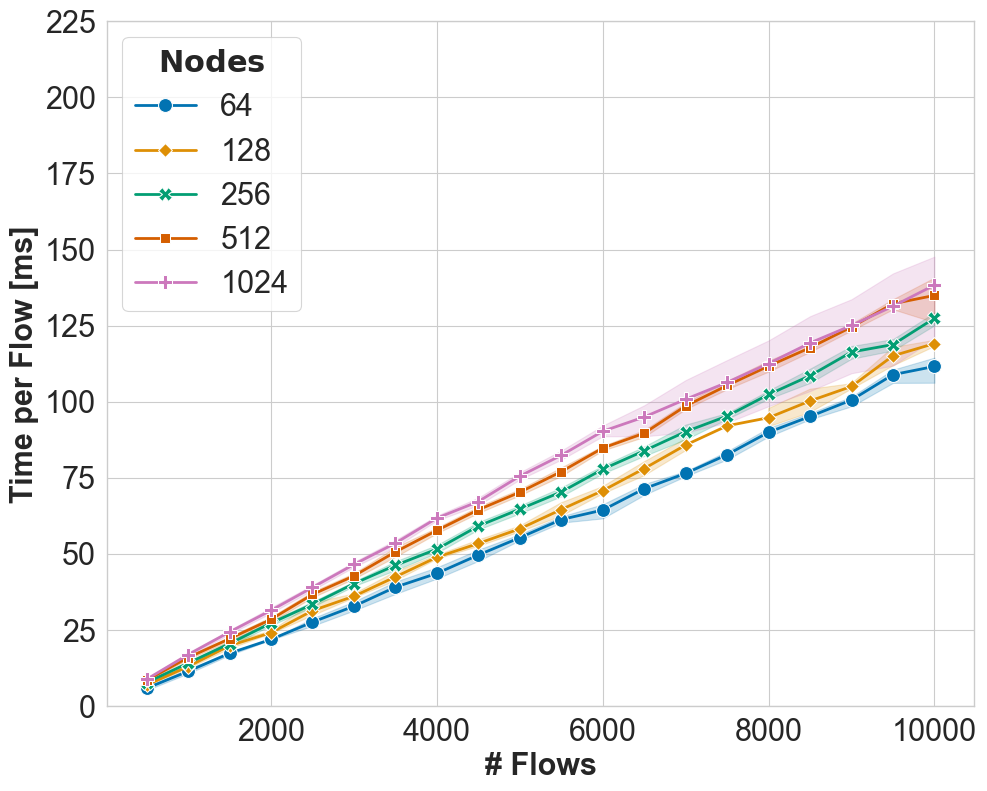

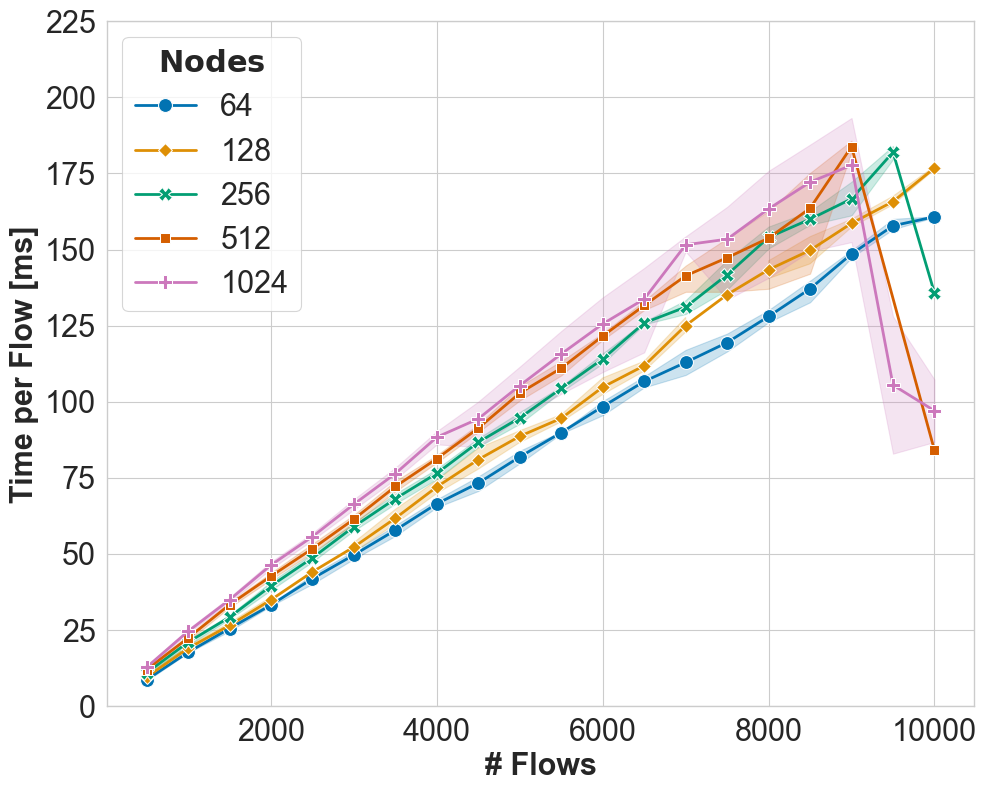

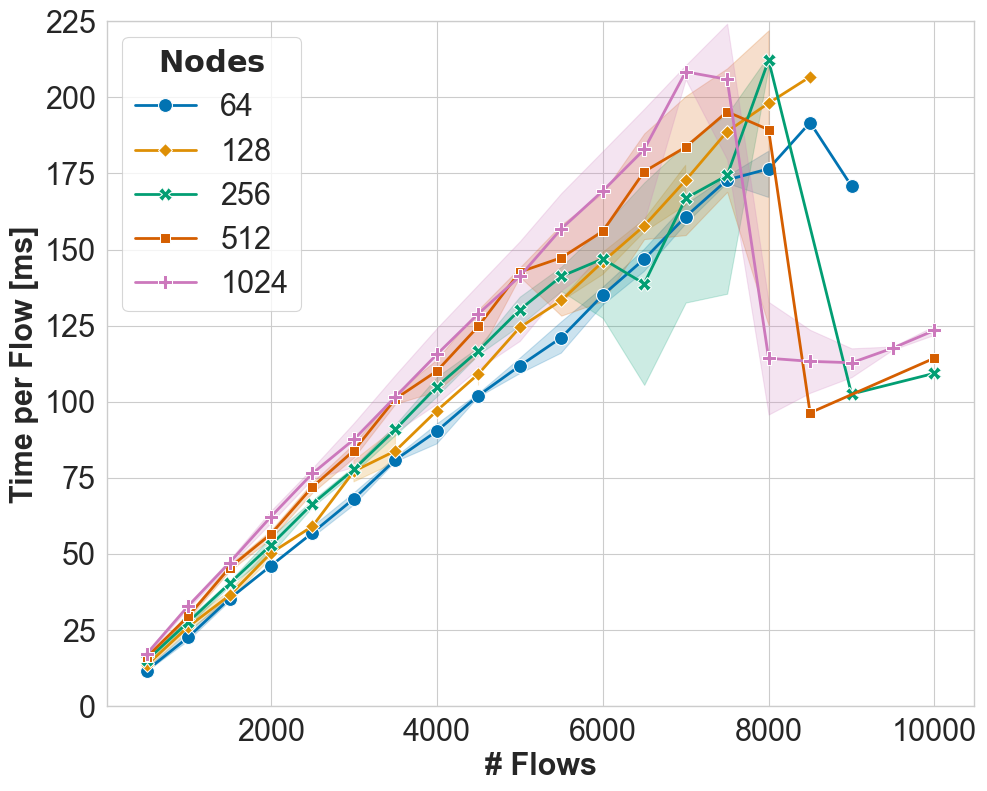

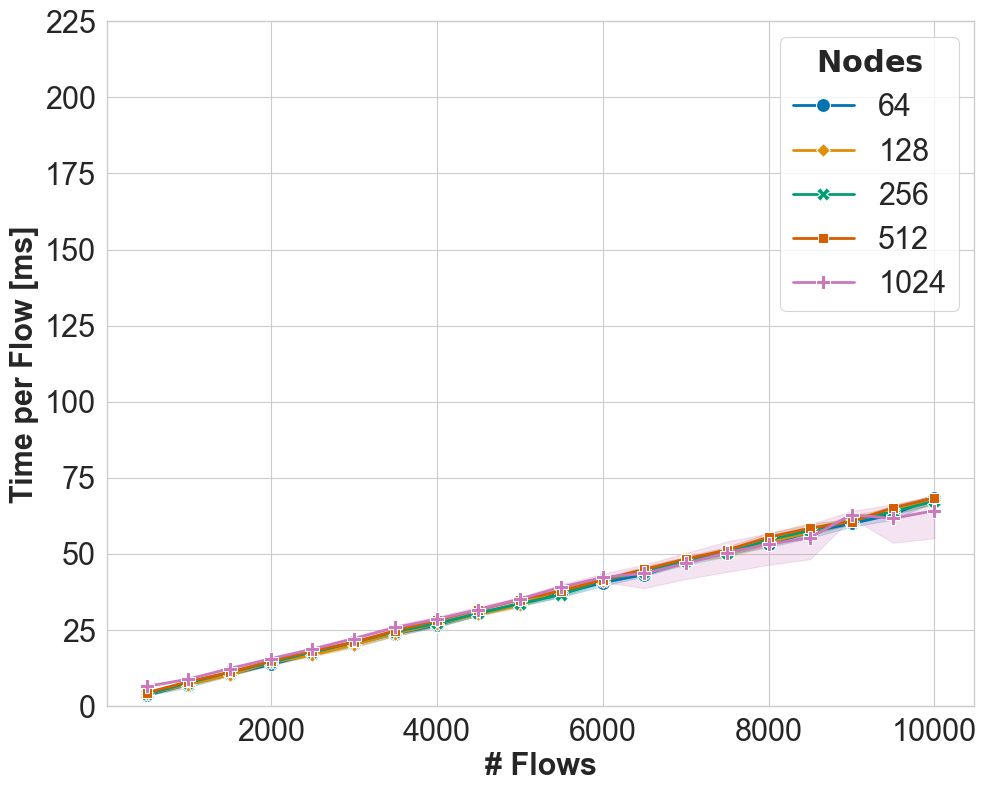

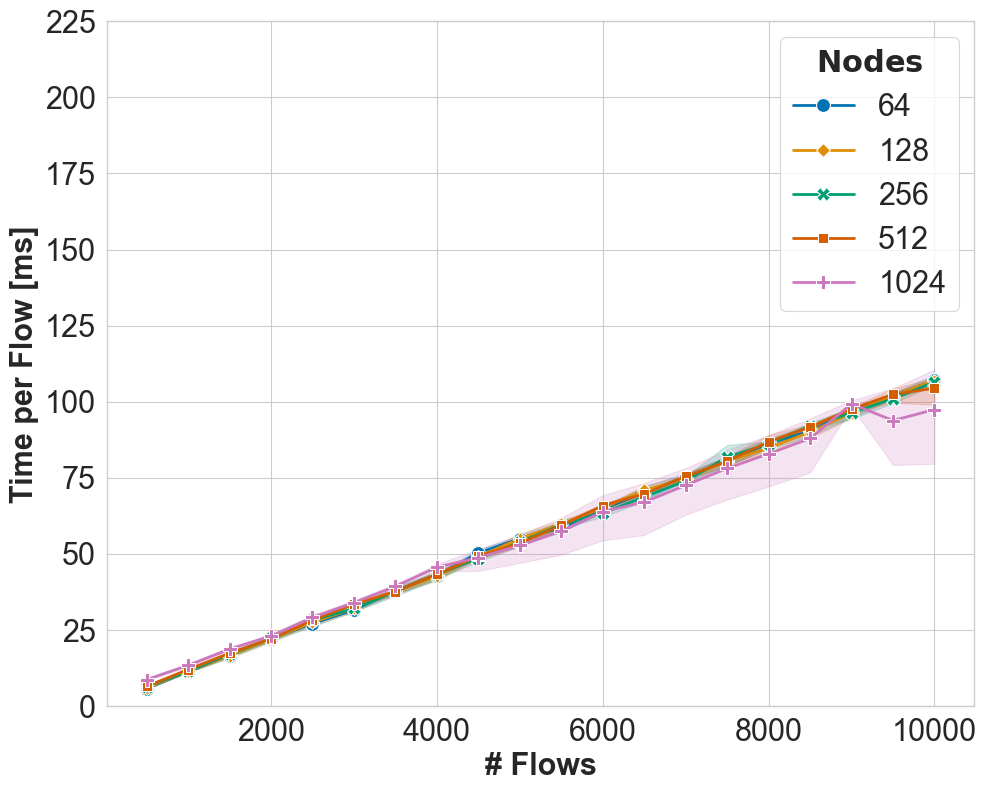

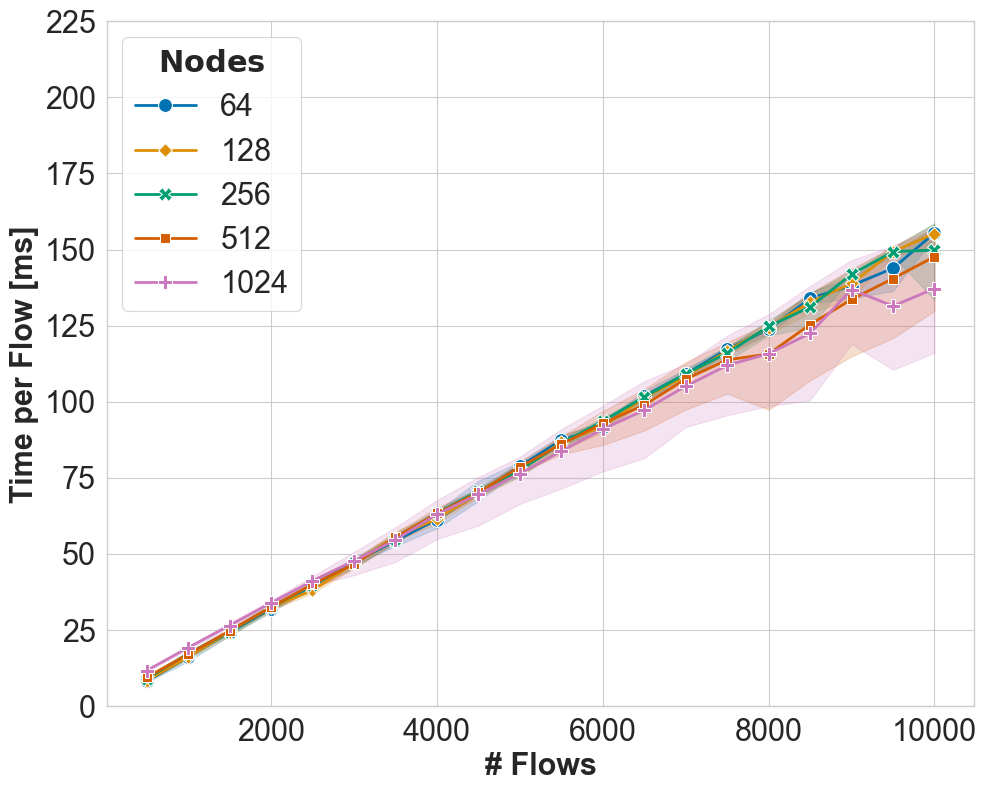

In [9]:
# Compute the time spent for 1 flow
df1 = df_success.copy()
df1['Time_per_Flow'] = (df1['Time'] / df1['Flows']) * 1000

def time_per_flow(df_tpf: pd.DataFrame, title: str, **kwargs):
    plt.figure(figsize=FIG_SIZE)
    sns.lineplot(
        data=df_tpf,
        hue_order=NODES,
        x="Flows",
        y="Time_per_Flow",
        hue="Nodes",
        style="Nodes",
        markers=True,
        errorbar=ERRORBAR,
        dashes=False,
    )

    # Set plot title and labels
    # plt.title(title, fontsize=FONT_SIZE)
    plt.xlabel('# Flows')
    plt.ylabel('Time per Flow [ms]')
    plt.ylim(Y_LIM_TPF)
    plt.legend(title=r'$\bf{Nodes}$')
    plt.tight_layout()
    path = PLOTS_DIR / "time-per-flow" / kwargs["topology"]
    path.mkdir(parents=True, exist_ok=True)
    plt.savefig(path / f"{kwargs['rp']}.pdf", format='pdf', dpi=600)
    plt.show()


by_topology(df1, time_per_flow)

#### CATPLOT 

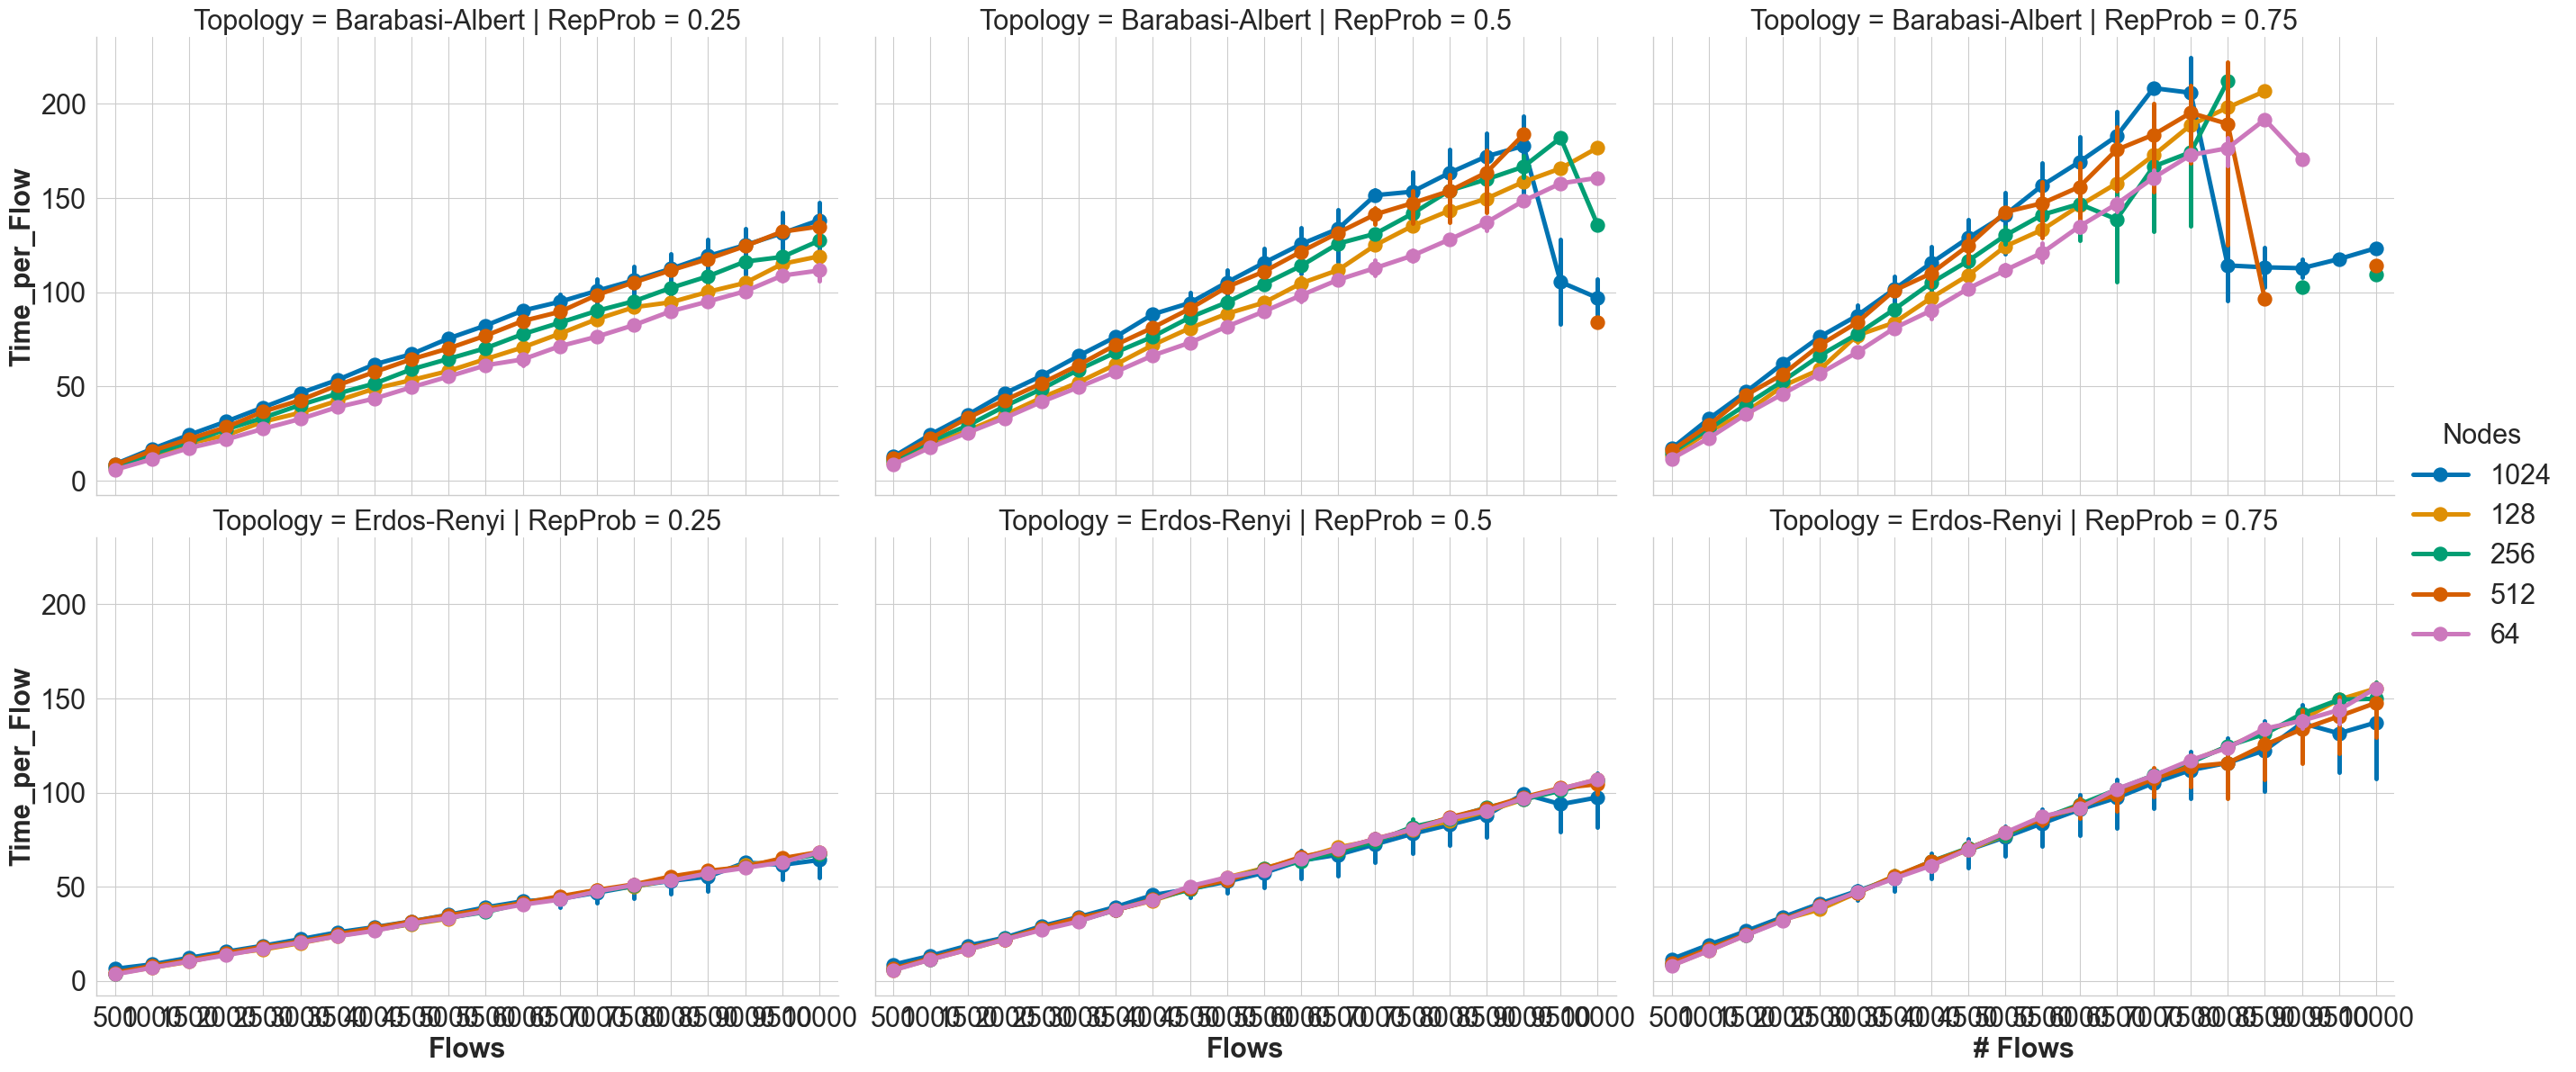

In [10]:
# Compute the time spent for 1 flow
df1 = df_success.copy()
df1['Time_per_Flow'] = (df1['Time'] / df1['Flows']) * 1000

time_per_flow_catplot = sns.catplot(
    data=df1,
    x="Flows",
    y="Time_per_Flow",
    hue="Nodes",
    col="RepProb",
    row="Topology",
    kind="point",
    legend_out=True,
    height=6,
    aspect=1.5,
    hue_order=sorted(NODES),
)

for ax in time_per_flow_catplot.axes.flat:
    ax.grid(True)
    # ax.set_ylim(Y_LIM_TPF)
    # ax.set_yscale(Y_SCALE)
    # ax.set_xscale("log")

plt.xlabel('# Flows')
plt.ylabel('Time per Flow')
# plt.savefig(CATPLOTS_DIR / "time-per-flow.pdf", format='pdf', dpi=600)
plt.show()

# FAILURES

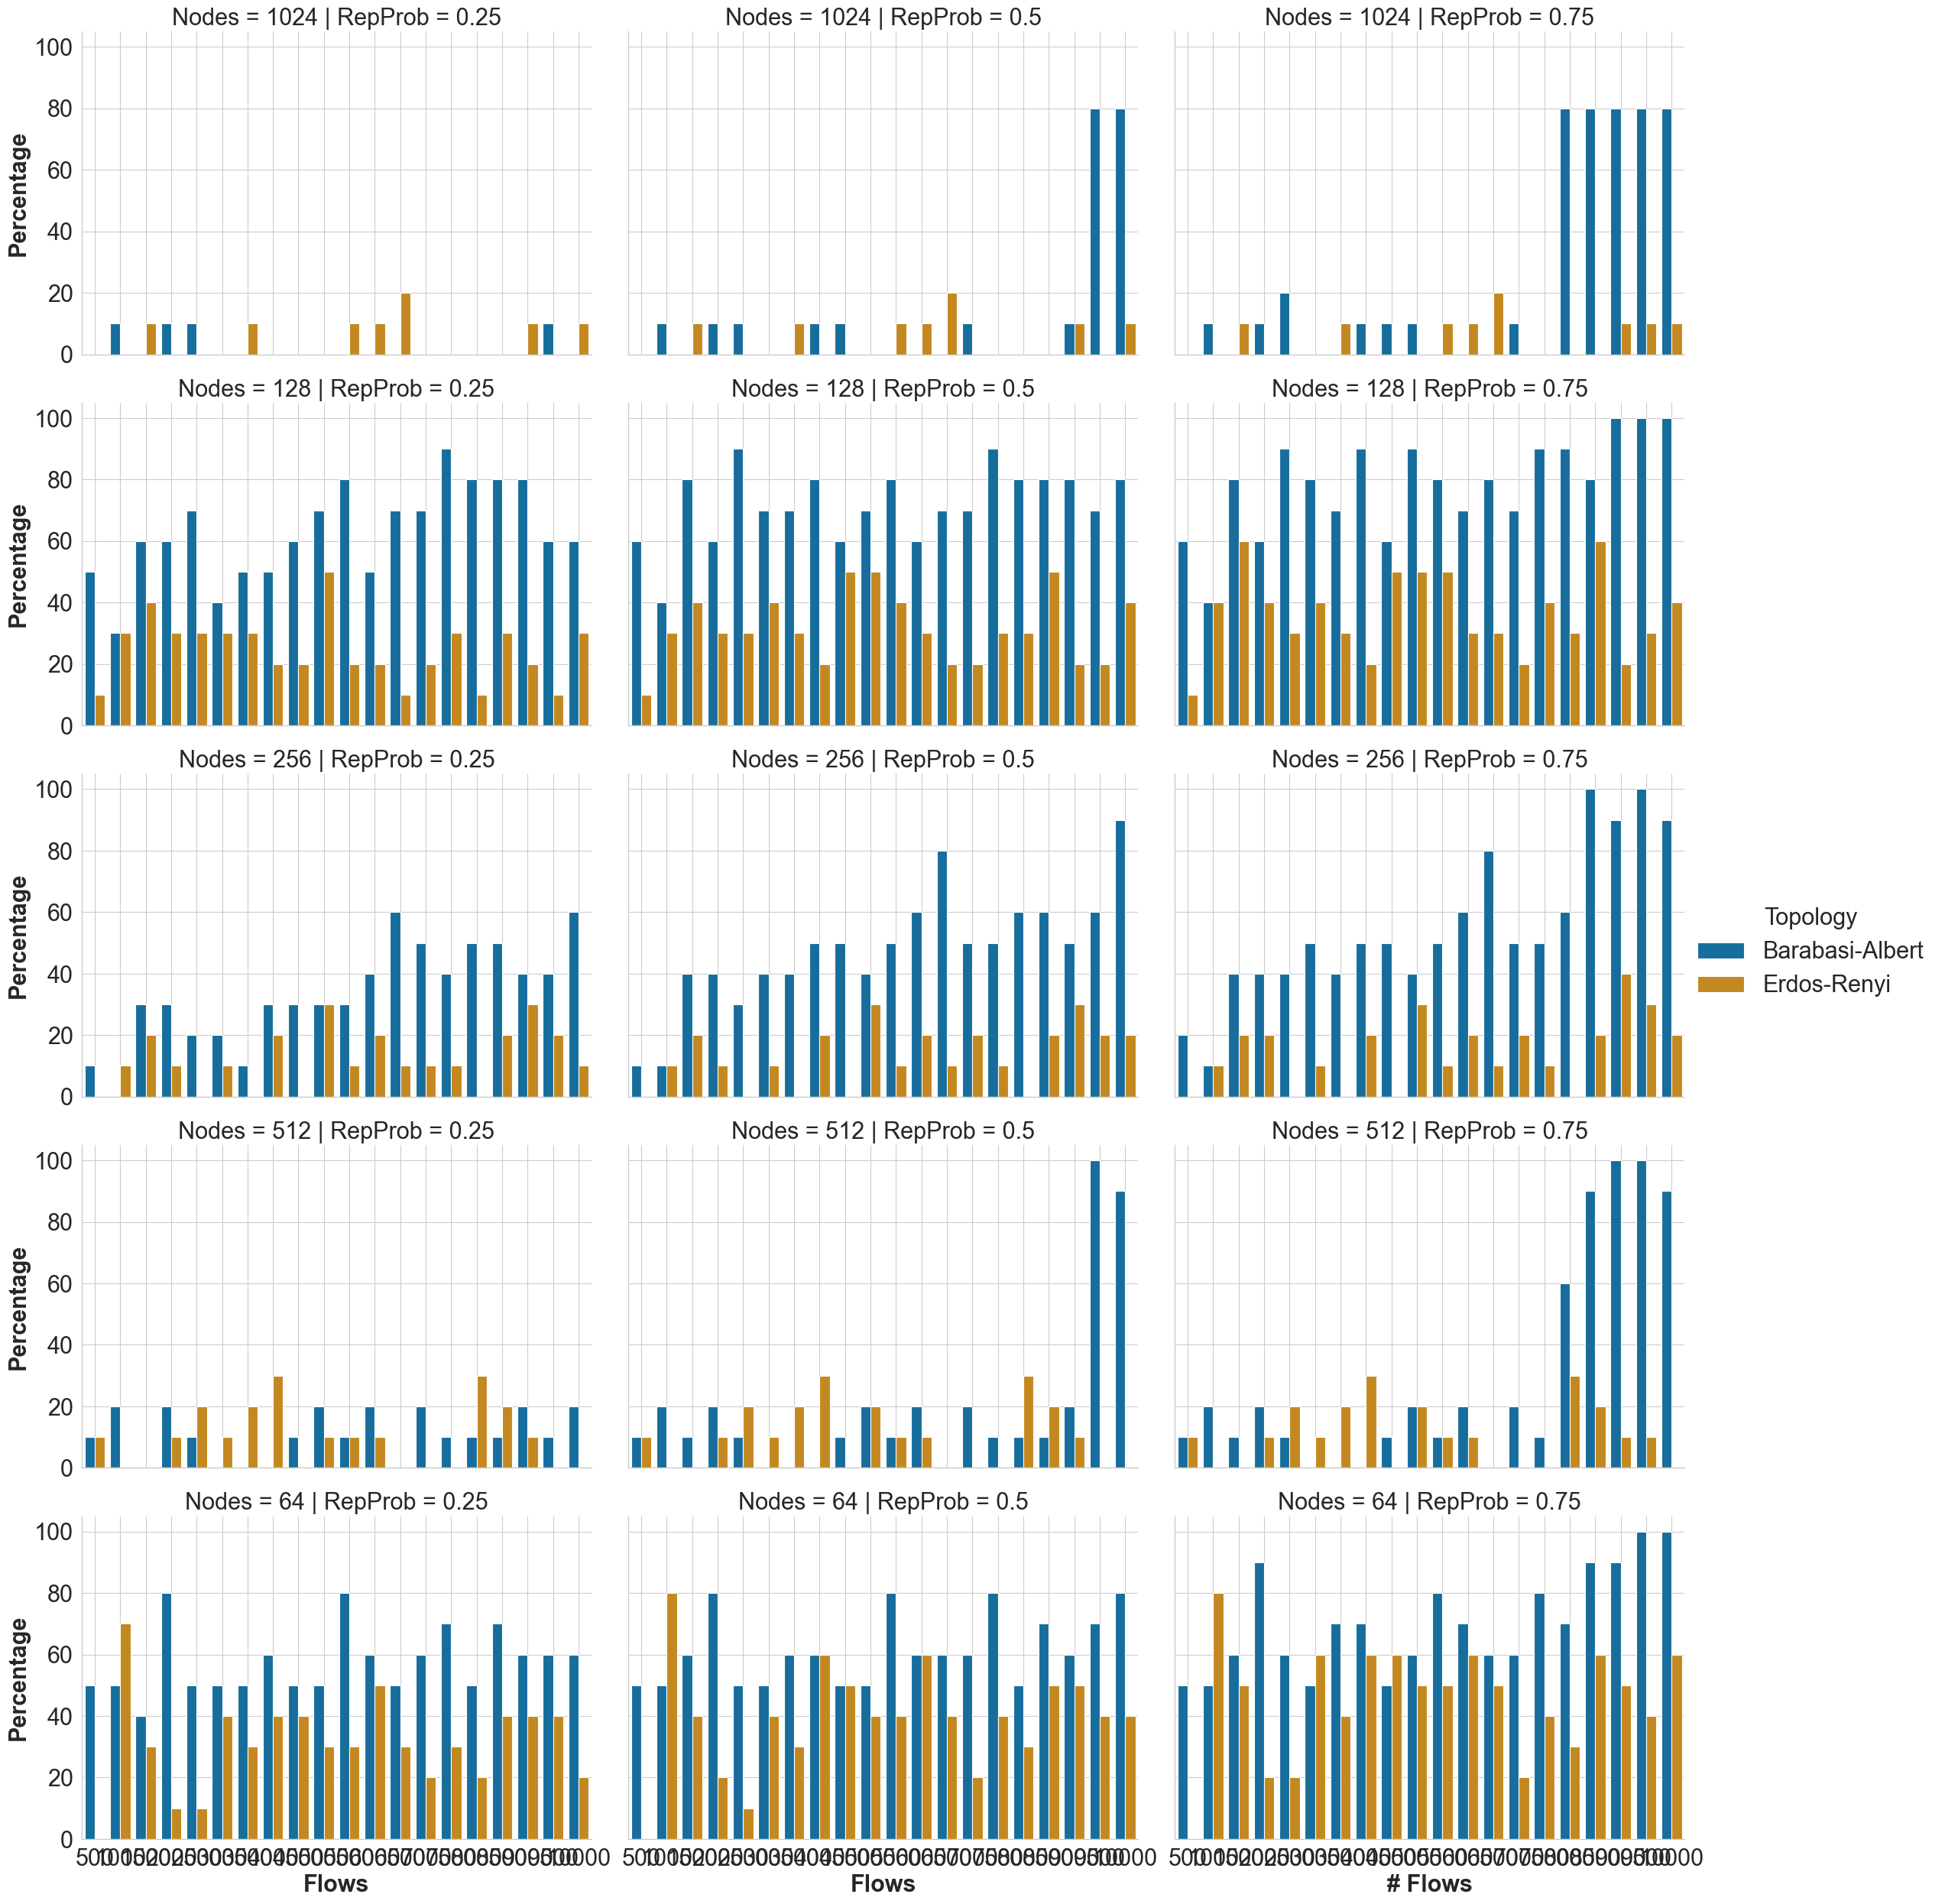

In [11]:
df2 = df_fails.copy()
group_by = ["Topology", "RepProb", "Nodes", "Flows"]
df_nodes = df.groupby(group_by).size().reset_index(name="Count")
df_nodes.set_index(group_by, inplace=True)

df_no = df2.groupby(group_by + ['Output']).size().reset_index(name="Count")
df_no.set_index(group_by, inplace=True)

df_no["Percentage"] = ((df_no["Count"] / df_nodes["Count"]) * 100).dropna()
df_no.reset_index(inplace=True)

g = sns.catplot(
    data=df_no,
    x="Flows",
    y="Percentage",
    hue="Topology",
    col="RepProb",
    row="Nodes",
    kind="bar",
    height=5,
    aspect=1.5,
    hue_order=sorted(TOPOLOGIES),
)

for ax in g.axes.flat:
    ax.grid(True)

plt.xlabel('# Flows')
plt.ylabel('% failures')
# plt.savefig(CATPLOTS_DIR / "failures.pdf", format='pdf', dpi=600)
plt.show()
